In [103]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from scipy.special import softmax

# Verify MPS (Apple Silicon GPU) availability
print(torch.backends.mps.is_available())  # should be True on M-series


True


In [104]:
# 2. Load Classification Dataset
classification_df = pd.read_csv("../data/classification_data.csv")
classification_df.head()

,id,text,label
0,1,DrugZ caused severe rashes in some participants.,Adverse Effect
1,2,No significant side effects were observed duri...,Positive Outcome
2,3,Participants were monitored every two weeks.,Neutral Observation
3,4,Increased liver enzymes were noted post-treatm...,Adverse Effect
4,5,Patients were instructed to maintain a food di...,Neutral Observation


In [105]:
classification_df['label'].value_counts().sort_index()

label
Adverse Effect         352
Neutral Observation    335
Positive Outcome       313
Name: count, dtype: int64

In [106]:
# 3. Encode Labels
label_encoder = LabelEncoder()
classification_df['label_encoded'] = label_encoder.fit_transform(classification_df['label'])
classification_df.head()

,id,text,label,label_encoded
0,1,DrugZ caused severe rashes in some participants.,Adverse Effect,0
1,2,No significant side effects were observed duri...,Positive Outcome,2
2,3,Participants were monitored every two weeks.,Neutral Observation,1
3,4,Increased liver enzymes were noted post-treatm...,Adverse Effect,0
4,5,Patients were instructed to maintain a food di...,Neutral Observation,1


In [107]:
# 4. Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    classification_df['text'].tolist(),
    classification_df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42
)

for i in range(5):
    print(f"Train Text: {train_texts[i]}")
    print(f"Train Label: {train_labels[i]}")
    print()

Train Text: No significant side effects were observed during the trial.
Train Label: 2

Train Text: Participants showed improved lung function after therapy with DrugC.
Train Label: 2

Train Text: Severe allergic reactions were observed following DrugB administration.
Train Label: 0

Train Text: Patients were instructed to maintain a food diary.
Train Label: 1

Train Text: Participants were monitored every two weeks.
Train Label: 1



In [108]:
# 5. Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [109]:
# 6. Dataset Class
torch.backends.cuda.matmul.allow_tf32 = True

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClassificationDataset(train_encodings, train_labels)
val_dataset = ClassificationDataset(val_encodings, val_labels)

In [110]:
# 7. Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
# 8. Training Arguments
training_args = TrainingArguments(
    # I/O
    output_dir="../results",            # where to save checkpoints & final model
    logging_dir="../logs",              # TensorBoard logs

    # Evaluation
    eval_strategy="steps",              # run evaluation by steps
    eval_steps=1,                       #   → every single training step
    eval_delay=0,                       #   → no warm‐up delay before first eval

    # Logging
    logging_strategy="steps",           # log training metrics by steps
    logging_steps=1,                    #   → every single training step

    # Checkpointing
    save_strategy="no",                 # disable auto‐saving
    load_best_model_at_end=False,       # (irrelevant when save_strategy="no")

    # Optimization
    learning_rate=2e-5,
    weight_decay=0.01,

    # Data
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    # Training length
    num_train_epochs=1,
)

In [112]:
# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [113]:
# 10. Baseline Evaluation
baseline_metrics = trainer.evaluate()
print("Zero-shot baseline:", baseline_metrics)

# get raw logits & labels
pred = trainer.predict(val_dataset)
logits, labels = pred.predictions, pred.label_ids

# convert to class‐predictions
preds = np.argmax(logits, axis=-1)

# compute the usual metrics
print("Accuracy:", accuracy_score(labels, preds))
print("F1 (weighted):", f1_score(labels, preds, average="weighted"))

# ROC-AUC (OvR)
probs = softmax(logits, axis=1)
y_bin = label_binarize(labels, classes=list(range(logits.shape[1])))
print("ROC-AUC (macro):", roc_auc_score(y_bin, probs, multi_class="ovr", average="macro"))

/Users/jmsung/miniconda3/envs/bio-ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Zero-shot baseline: {'eval_loss': 1.095420479774475, 'eval_model_preparation_time': 0.0009, 'eval_runtime': 0.3123, 'eval_samples_per_second': 640.368, 'eval_steps_per_second': 41.624}
Accuracy: 0.36
F1 (weighted): 0.19058823529411764
ROC-AUC (macro): 0.5160026041914456


In [114]:
# 11. Train
trainer.train()

/Users/jmsung/miniconda3/envs/bio-ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Model Preparation Time
1,1.089300,1.075274,0.000900
2,1.051700,1.055662,0.000900
3,1.086400,1.031947,0.000900
4,1.049800,1.005873,0.000900
5,1.013600,0.978250,0.000900
6,0.997400,0.948553,0.000900
7,1.008400,0.917241,0.000900
8,0.909700,0.884733,0.000900
9,0.866600,0.851802,0.000900
10,0.843100,0.816130,0.000900


TrainOutput(global_step=50, training_loss=0.5343706792593003, metrics={'train_runtime': 14.3512, 'train_samples_per_second': 55.744, 'train_steps_per_second': 3.484, 'total_flos': 3104760024000.0, 'train_loss': 0.5343706792593003, 'epoch': 1.0})

In [115]:
# 12. Evaluation
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.21674250066280365, 'eval_model_preparation_time': 0.0009, 'eval_runtime': 0.1815, 'eval_samples_per_second': 1102.178, 'eval_steps_per_second': 71.642, 'epoch': 1.0}


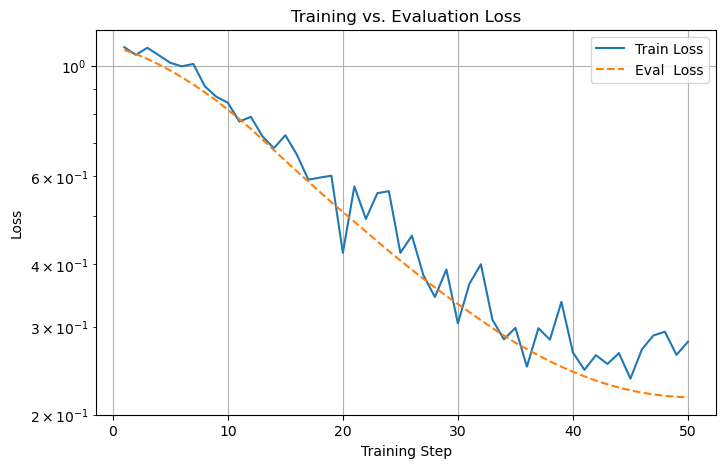

In [120]:
# 13. Plotting Training and Evaluation Loss

# 1) Pull out the log history
hist = pd.DataFrame(trainer.state.log_history)

# 2) Separate train-loss and eval-loss entries
train_df = hist[hist['loss'].notnull()]
eval_df  = hist[hist['eval_loss'].notnull()]

# 3) One figure, two curves
plt.figure(figsize=(8,5))
plt.plot(train_df['step'], train_df['loss'],     label='Train Loss')
plt.plot(eval_df ['step'], eval_df ['eval_loss'], label='Eval  Loss', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.savefig("../results/figs/training_vs_eval_loss.png", dpi=300, bbox_inches="tight")
plt.show()


In [117]:
# 14. Predictions and Metrics

# 1) Run predictions
pred_out = trainer.predict(val_dataset)
logits   = pred_out.predictions      # (n_samples, n_classes)
y_true   = pred_out.label_ids        # (n_samples,)

# 2) Hard preds & metrics
preds = np.argmax(logits, axis=-1)
acc   = accuracy_score(y_true, preds)
f1    = f1_score(y_true, preds, average="weighted")

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 (weighted): {f1:.4f}\n")
print(classification_report(
    y_true,
    preds,
    target_names=label_encoder.classes_,
    digits=4
))

Validation Accuracy: 1.0000
Validation F1 (weighted): 1.0000

                     precision    recall  f1-score   support

     Adverse Effect     1.0000    1.0000    1.0000        72
Neutral Observation     1.0000    1.0000    1.0000        62
   Positive Outcome     1.0000    1.0000    1.0000        66

           accuracy                         1.0000       200
          macro avg     1.0000    1.0000    1.0000       200
       weighted avg     1.0000    1.0000    1.0000       200



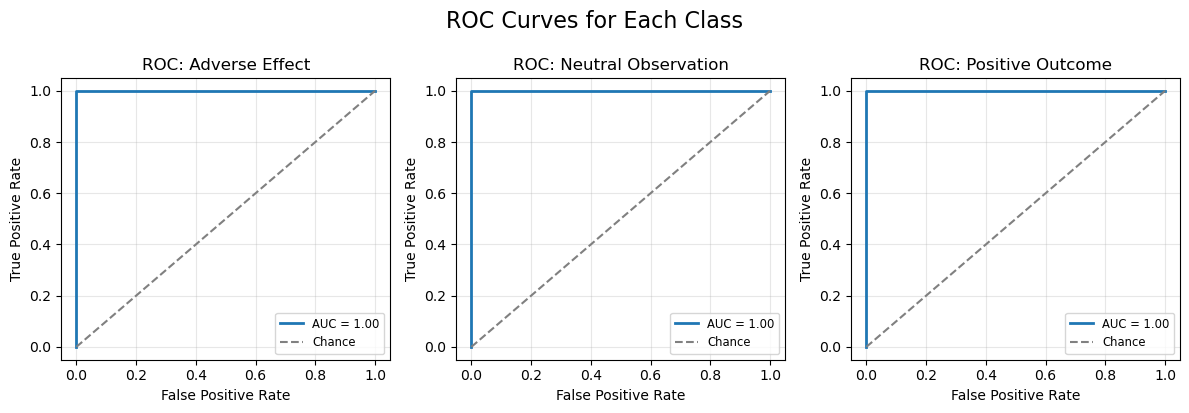

In [122]:
# 14. ROC Curves for Each Class

# 1) Softmax → probabilities → binarize for OvR ROC
probs     = softmax(logits, axis=1)
n_classes = probs.shape[1]
y_bin     = label_binarize(y_true, classes=list(range(n_classes)))

# 2) Plot each class’s ROC in its own subplot
n_rows, n_cols = 1, n_classes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4))
axes = axes.flatten()

for i, ax in enumerate(axes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc     = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance")
    ax.set_title(f"ROC: {label_encoder.classes_[i]}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize="small")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("ROC Curves for Each Class", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)  # Adjust top to make room for the title
plt.savefig("../results/figs/roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()


In [119]:
# 15. Save Model and Tokenizer

# 1) Make sure the directory exists
out_dir = "../results/models/distilbert-classification"
os.makedirs(out_dir, exist_ok=True)

# 2) Save the config and the state_dict yourself
model.config.save_pretrained(out_dir)  
torch.save(model.state_dict(), os.path.join(out_dir, "pytorch_model.bin"))

# 3) Save the tokenizer
tokenizer.save_pretrained(out_dir)


('../results/models/distilbert-classification/tokenizer_config.json',
 '../results/models/distilbert-classification/special_tokens_map.json',
 '../results/models/distilbert-classification/vocab.txt',
 '../results/models/distilbert-classification/added_tokens.json',
 '../results/models/distilbert-classification/tokenizer.json')

# Result
* After just one epoch of fine-tuning, the pretrained DistilBERT model achieves perfect validation performance (Accuracy = F1 = AUC = 1.0) for all 3 classes.